In [191]:
import pandas as pd
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
df = pd.read_csv('/flood_records.csv')
print(f"Original Dataset Size: {df.shape}")

Original Dataset Size: (25250, 22)


In [193]:

df.head()

,record_id,district,place_name,latitude,longitude,elevation_m,distance_to_river_m,landcover,soil_type,water_supply,...,population_density_per_km2,built_up_percent,urban_rural,rainfall_7d_mm,monthly_rainfall_mm,historical_flood_count,nearest_hospital_km,nearest_evac_km,flood_occurrence_current_event,record_date
0,F112602,Matara,Kirivila Central,9.266324,80.336403,72.0,2711.0,Agriculture,Clay,Municipal,...,395.0,28.8,Rural,128.9,317.4,NaN,6.95,0.27,Nan,08/12/2025
1,F112074,Ratnapura,Kudakanda South,9.307797,81.468502,42.0,140.6,Forest,Loamy,Rainwater harvesting,...,271.0,17.2,Rural,62.3,380.1,1.0,5.25,4.77,Yes,10/15/2025
2,F111248,Ampara,Ihalakanda West,6.655725,81.163861,115.0,1572.7,Urban,Silty,Tube-well,...,278.0,23.9,Urban,19.8,390.9,0.0,15.24,0.37,No,06/19/2024
3,F106630,Mannar,Mahapola,9.393612,80.184942,141.0,1519.2,Scrub,Silty,Municipal,...,98.0,21.7,Rural,64.7,269.3,0.0,9.50,15.80,No,01/08/2024
4,F103358,Kegalle,Ihalanuwara South,7.171507,81.465928,101.0,NaN,Urban,Peaty,Well,...,672.0,12.7,Urban,0.2,60.2,0.0,22.19,13.59,No,07/04/2024


In [194]:
# 1. preprocessing and cleaning
# dropping identifiers
cols_to_drop = ['record_id', 'record_date']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
df.head()

,district,place_name,latitude,longitude,elevation_m,distance_to_river_m,landcover,soil_type,water_supply,electricity,road_quality,population_density_per_km2,built_up_percent,urban_rural,rainfall_7d_mm,monthly_rainfall_mm,historical_flood_count,nearest_hospital_km,nearest_evac_km,flood_occurrence_current_event
0,Matara,Kirivila Central,9.266324,80.336403,72.0,2711.0,Agriculture,Clay,Municipal,Grid,Good (Paved),395.0,28.8,Rural,128.9,317.4,NaN,6.95,0.27,Nan
1,Ratnapura,Kudakanda South,9.307797,81.468502,42.0,140.6,Forest,Loamy,Rainwater harvesting,Mixed,Fair,271.0,17.2,Rural,62.3,380.1,1.0,5.25,4.77,Yes
2,Ampara,Ihalakanda West,6.655725,81.163861,115.0,1572.7,Urban,Silty,Tube-well,Off-grid (Solar),Good (Paved),278.0,23.9,Urban,19.8,390.9,0.0,15.24,0.37,No
3,Mannar,Mahapola,9.393612,80.184942,141.0,1519.2,Scrub,Silty,Municipal,Grid,Good (Paved),98.0,21.7,Rural,64.7,269.3,0.0,9.50,15.80,No
4,Kegalle,Ihalanuwara South,7.171507,81.465928,101.0,NaN,Urban,Peaty,Well,Grid,Good (Paved),672.0,12.7,Urban,0.2,60.2,0.0,22.19,13.59,No


In [195]:
# check for Missing Values
print("--- MISSING VALUES PER COLUMN ---")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

--- MISSING VALUES PER COLUMN ---
elevation_m                   1207
distance_to_river_m           1239
population_density_per_km2    1256
built_up_percent              1259
historical_flood_count        1260
nearest_hospital_km           1266
nearest_evac_km               1241
dtype: int64


In [196]:
# standardize to 0 and 1 (Yes=1, No=0)
df['flood_occurrence_current_event'] = df['flood_occurrence_current_event'].astype(str).str.strip().str.capitalize().map({'Yes': 1, 'No': 0})

# remove rows where the 'flood_occurrence_current_event' is missing
df = df.dropna(subset=['flood_occurrence_current_event'])

print(df['flood_occurrence_current_event'].head())

1    1.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: flood_occurrence_current_event, dtype: float64


In [197]:
# column names with non missing values
non_missing_columns = df.columns[df.notna().all()].tolist()

print("--- CLEAN COLUMNS ---")
print(non_missing_columns)

--- CLEAN COLUMNS ---
['district', 'place_name', 'latitude', 'longitude', 'landcover', 'soil_type', 'water_supply', 'electricity', 'road_quality', 'urban_rural', 'rainfall_7d_mm', 'monthly_rainfall_mm', 'flood_occurrence_current_event']


In [198]:
# check for duplication
print("\n--- DUPLICATE ROWS ---")
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")


--- DUPLICATE ROWS ---
Total duplicate rows: 227


In [199]:
# handle duplicates
df = df.drop_duplicates()

print("\n--- DUPLICATE ROWS ---")
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")


--- DUPLICATE ROWS ---
Total duplicate rows: 0


In [200]:
# for the elevation_m sri lanka's max height is ~2524m.
df.loc[(df['elevation_m'] > 2524), 'elevation_m'] = np.nan

In [201]:
target_cols = [
    'built_up_percent', 'historical_flood_count', 'nearest_hospital_km',
    'nearest_evac_km', 'population_density_per_km2', 'elevation_m', 'distance_to_river_m'
]

DISTANCE_THRESHOLD_KM = 1.5
EARTH_RADIUS_KM = 6371

df_rad = np.deg2rad(df[['latitude', 'longitude']])
tree = BallTree(df_rad, metric='haversine')

for col in target_cols:
    missing_mask = df[col].isna()
    if not missing_mask.any():
        continue

    missing_coords = df_rad[missing_mask]

    dists, indices = tree.query(missing_coords, k=3)
    dists_km = dists * EARTH_RADIUS_KM

    avg_dists = dists_km.mean(axis=1)

    imputed_values = pd.Series(index=df[missing_mask].index, dtype=float)
    for i, (idx, dist) in enumerate(zip(df[missing_mask].index, avg_dists)):
        if dist <= DISTANCE_THRESHOLD_KM:
            # using neighbors if they are close enough
            neighbor_indices = indices[i]
            neighbor_values = df.iloc[neighbor_indices][col].dropna()
            if not neighbor_values.empty:
                imputed_values.loc[idx] = neighbor_values.mean()

    df.loc[missing_mask, col] = imputed_values

    # fallback if too far away
    df[col] = df[col].fillna(df.groupby(['district', 'place_name'])[col].transform('median'))
    df[col] = df[col].fillna(df[col].median())

print(f"Total missing values: {missing_mask.sum()}")
print(f"Values filled by neighbors: {imputed_values.notna().sum()}")

Total missing values: 1163
Values filled by neighbors: 1085


In [202]:
print(f"Cleaned Dataset Size: {df.shape}")
print("\nMissing Values Remaining:")
print(df.isnull().sum())
print("\nTarget Class Distribution:")
print(df['flood_occurrence_current_event'].value_counts())

Cleaned Dataset Size: (23738, 20)

Missing Values Remaining:
district                          0
place_name                        0
latitude                          0
longitude                         0
elevation_m                       0
distance_to_river_m               0
landcover                         0
soil_type                         0
water_supply                      0
electricity                       0
road_quality                      0
population_density_per_km2        0
built_up_percent                  0
urban_rural                       0
rainfall_7d_mm                    0
monthly_rainfall_mm               0
historical_flood_count            0
nearest_hospital_km               0
nearest_evac_km                   0
flood_occurrence_current_event    0
dtype: int64

Target Class Distribution:
flood_occurrence_current_event
0.0    21376
1.0     2362
Name: count, dtype: int64


In [203]:
# remove non-predictive columns
df_ml = df.drop(columns=['place_name'], errors='ignore')

In [204]:
# one-hot encoding
df_ml = pd.get_dummies(df_ml, columns=['district', 'landcover', 'soil_type', 'water_supply', 'electricity', 'road_quality', 'urban_rural'])

# define features
X = df_ml.drop('flood_occurrence_current_event', axis=1)
# define targets
y = df_ml['flood_occurrence_current_event']

In [205]:
!pip install -U imbalanced-learn

In [206]:
# fixing imbalance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Preprocessing Finalized!")
print(f"Original shape: {X.shape}")
print(f"Resampled shape (Balanced): {X_resampled.shape}")
print(f"New Target Distribution:\n{pd.Series(y_resampled).value_counts()}")

Preprocessing Finalized!
Original shape: (23738, 62)
Resampled shape (Balanced): (42752, 62)
New Target Distribution:
flood_occurrence_current_event
1.0    21376
0.0    21376
Name: count, dtype: int64


In [207]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [208]:
# 2. Training
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, random_state=42)

In [209]:
# 3. prediction and evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print("--- MODEL PERFORMANCE ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- MODEL PERFORMANCE ---
Accuracy: 0.9482
F1-Score: 0.9488
ROC-AUC: 0.9930

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      4304
         1.0       0.93      0.97      0.95      4247

    accuracy                           0.95      8551
   macro avg       0.95      0.95      0.95      8551
weighted avg       0.95      0.95      0.95      8551



In [210]:
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(model, 'flood_model.pkl')
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')

['feature_columns.pkl']

In [211]:
import shap
import matplotlib.pyplot as plt

In [212]:
!pip install shap

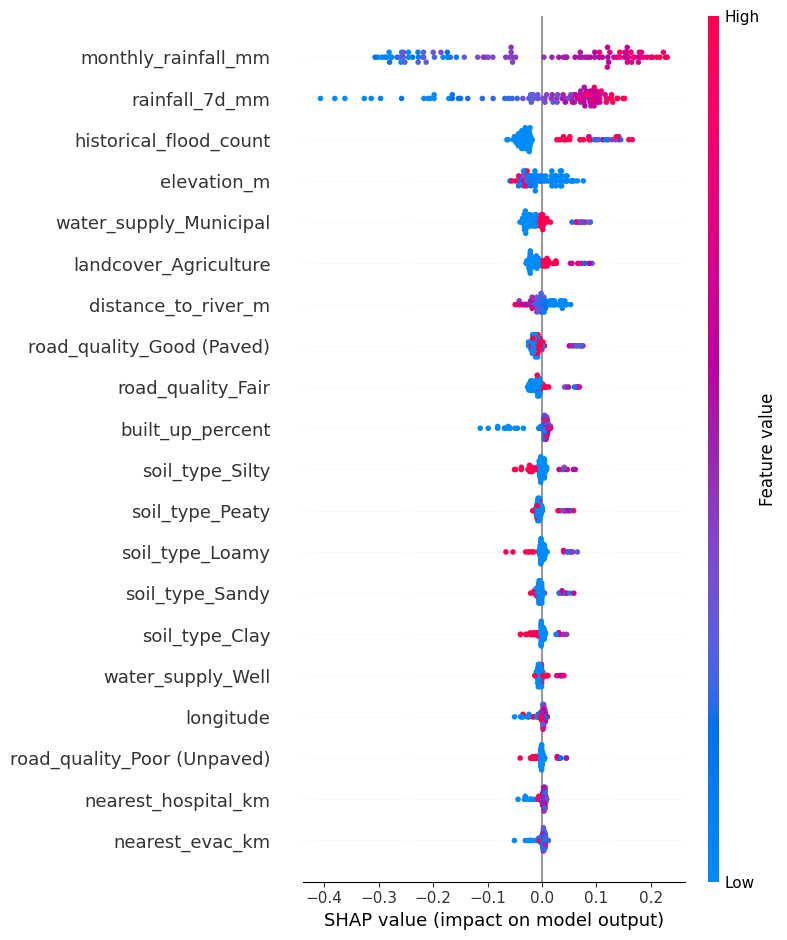

In [213]:
# 4. Visualization
# SHAP
explainer = shap.TreeExplainer(model)
X_sample = X_test[:100]

shap_values = explainer.shap_values(X_sample)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values[:, :, 1] if len(shap_values.shape) == 3 else shap_values[1],
    X_sample,
    feature_names=X.columns,
    plot_type="dot"
)

In [214]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

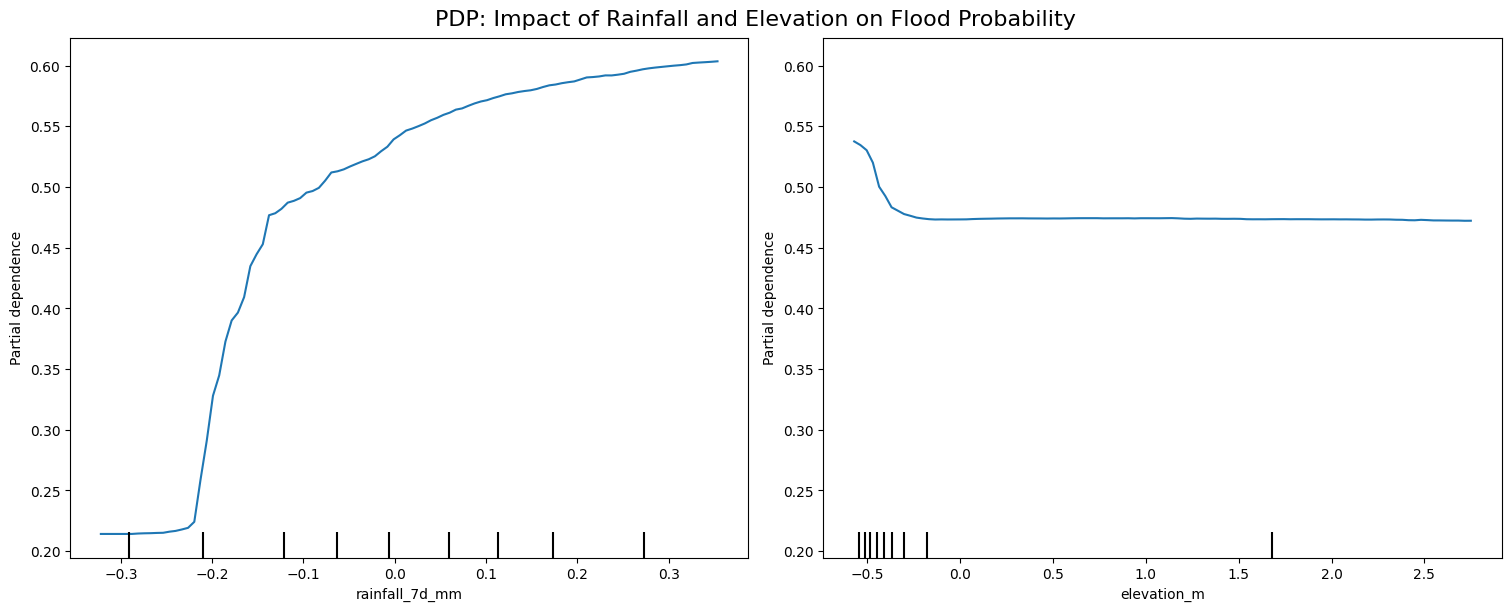

In [215]:
# PDP
pdp_features = ['rainfall_7d_mm', 'elevation_m']

all_feature_names = X.columns.tolist()
fig, ax = plt.subplots(1, 2, figsize=(15, 6), layout="constrained")

display = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test[:500],
    features=pdp_features,
    feature_names=all_feature_names,
    ax=ax
)

plt.suptitle("PDP: Impact of Rainfall and Elevation on Flood Probability", fontsize=16)
plt.show()

In [216]:
!pip install lime

In [217]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

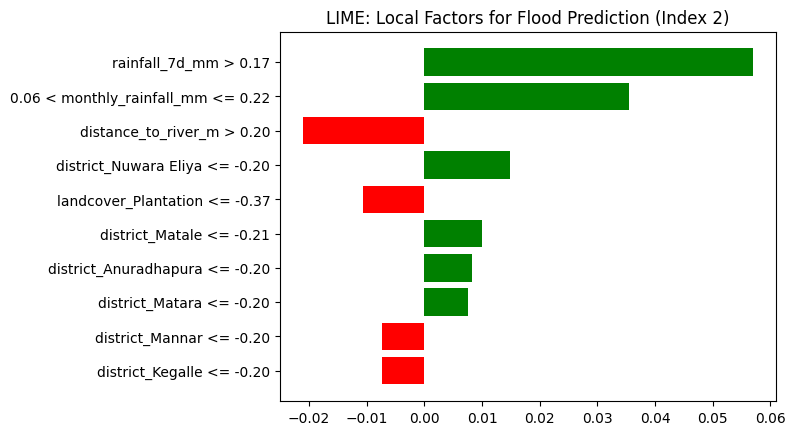

In [218]:
# LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns.tolist(),
    class_names=['No Flood', 'Flood'],
    mode='classification'
)

instance_idx = np.where(y_test == 1)[0][0]
instance = X_test[instance_idx]

exp = explainer_lime.explain_instance(
    instance,
    model.predict_proba,
    num_features=10
)

exp.as_pyplot_figure()
plt.title(f"LIME: Local Factors for Flood Prediction (Index {instance_idx})")
plt.show()

<Figure size 800x600 with 0 Axes>

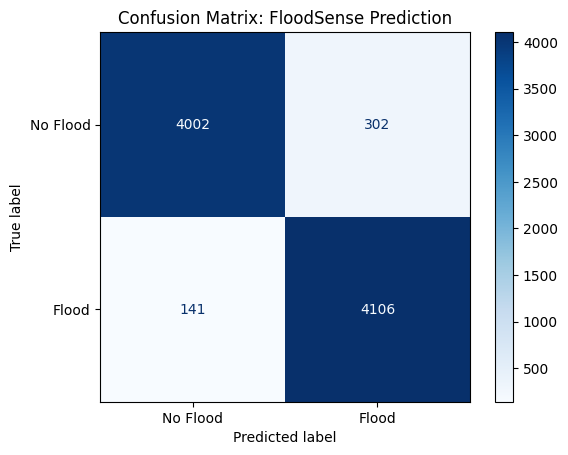

In [223]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Flood', 'Flood'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: FloodSense Prediction')

plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

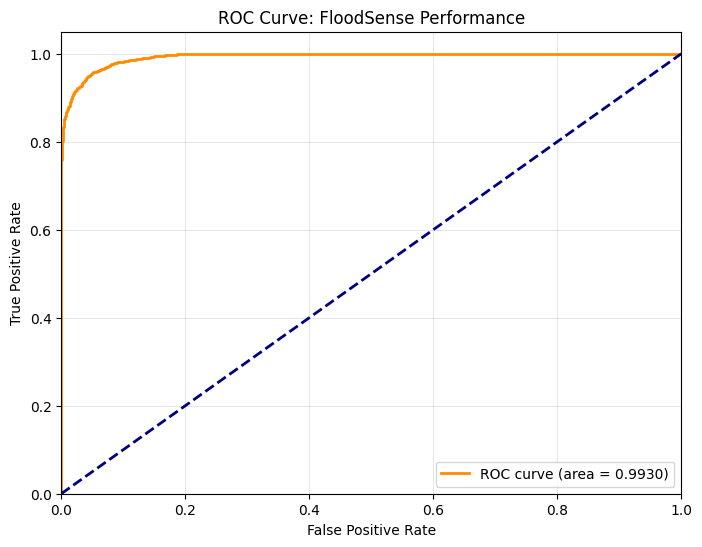

In [224]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: FloodSense Performance')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [219]:
from google.colab import files

In [220]:
files.download('flood_model.pkl')
files.download('scaler.pkl')
files.download('feature_columns.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>